In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

### Write function as I explore in notebook

In [2]:
# Read data 
# specify file name

exp_no = 104
file_name = f"{exp_no}_SHT_SMD.txt"
file_path = f"../data/01_raw/{file_name}"
df = pd.read_csv(file_path, sep=',', usecols=['timestamp', 'SHT40_temp', 'SHT40_Humidity', 'A1_Sensor', 'A1_Resistance'])




In [3]:
# identify all peaks including high and low peaks, and then find the index of smaller peak by compariing
# the height of two adjacent peaks
# put the index of the smaller and larger peaks into two lists

def _hi_lo_peak(x: pd.DataFrame) -> pd.DataFrame:
    peaks, properties = find_peaks(x['A1_Sensor'], width=50, height=1)
    peak_heights = properties['peak_heights']
# Determine smaller and larger peaks
    smaller_peaks, larger_peaks = [], []
    for i in range(len(peaks) - 1):
        if peak_heights[i] > peak_heights[i + 1]:
            larger_peaks.append(peaks[i])
            smaller_peaks.append(peaks[i + 1])
    # smaller_peaks_df = x.iloc[smaller_peaks]
    return smaller_peaks

In [5]:
def preprocess_data_stack(sp: pd.DataFrame, df: pd.DataFrame) -> pd.DataFrame:
    df_stacked_list = []
    for i in range(len(sp) - 1):
        df_subset = df.iloc[sp[i]:sp[i + 1]].copy()
        df_subset['exp_no'] = i
        df_subset['timestamp'] -= df_subset['timestamp'].iloc[0]
        df_stacked_list.append(df_subset)
        df_stacked = pd.concat(df_stacked_list, ignore_index=True)
    return df_stacked

In [24]:
df_stacked = preprocess_data_stack(_hi_lo_peak(df), df)

In [26]:
df_stacked.tail()

,timestamp,SHT40_temp,SHT40_Humidity,A1_Sensor,A1_Resistance,exp_no
844593,181900,26.56,40.67,1598.0,2311577.00,231
844594,181949,26.56,40.72,1596.0,2314661.50,231
844595,182000,26.58,40.80,1597.0,2313118.25,231
844596,182050,26.57,40.84,1601.0,2306964.50,231
844597,182100,26.58,40.89,1601.0,2306964.50,231


# Bucketing
Bucketing all time variable under uniformed buckets to align features
- Define minimum t and maximum t
- Form a bucket per 200ms
- Average n number of values in the bucket

examine all exp_no
determine min and max that will be applied uniformly


In [27]:
# group experiments by using groupby function
# create a new column called bin
# the number of bin is predefined by user i.e., 1500
# group the data entries into 1500 bins
# average the values within each bin

def _group_by_bin(df_stacked: pd.DataFrame, num_bins: int) -> pd.DataFrame:
    df_list = []
    grouped = df_stacked.groupby('exp_no')
    for name, group in grouped:
        group['bin'] = pd.cut(group['timestamp'], bins=num_bins, labels=False)
        df_list.append(group)
    return pd.concat(df_list)

bin_df = _group_by_bin(df_stacked, 1500)
# bucketed.tail()

In [35]:
# check all exp_no have the same number of bins
# if they are all the same print 1 if not print 0

def _check_bins(df: pd.DataFrame) -> bool:
    grouped = df.groupby('exp_no')
    unique_bins = None
    for name, group in grouped:
        if unique_bins is None:
            unique_bins = len(group['bin'].unique())
        elif len(group['bin'].unique()) != unique_bins:
            return False
    return True

_check_bins(bin_df)


True

In [36]:
# average data within each bucket to give only one value per bucket
# group by experiment number and timestamp_bucket
# drop timestamp column
# calculate mean of all columns


def _average_bin(bin_df: pd.DataFrame) -> pd.DataFrame:
    bin_df = bin_df.drop(columns=['timestamp'])
    grouped = bin_df.groupby(['exp_no', 'bin'])
    return grouped.mean()

In [37]:
# save averaged data to csv in intermediate folder
averaged = _average_bin(bin_df)
averaged.to_csv(f"../data/02_intermediate/norm_averaged_bin.csv")

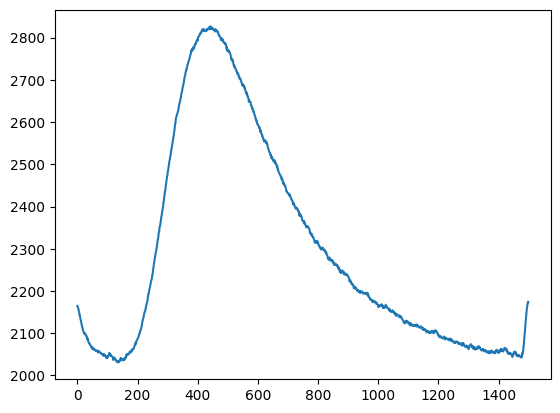

In [41]:
# plot the graph of a specified exp_no in terms of A1_sensor against bin
# specify exp_no
# plot the graph of A1_sensor against bin

def _plot_graph(averaged: pd.DataFrame, exp_no: int) -> None:
    plt.plot(averaged.loc[exp_no]['A1_Sensor'])
    plt.show()

_plot_graph(averaged, 120)
